# Deep Residual Learning for Image Recognition: CIFAR-10 

This notebook provides a PyTorch implementation of *Deep Residual Learning for Image Recogniton* by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Han Sun which achived state of the art in 2015 by winning the ILSVRC and COCO challenges.

The key insight provided by the paper is that "shortcuts" between network layers allow layers to model the residual function and improve the performance of deeper networks with more than 20 layers. This result is reproduced here, although with 2% higher test error for all results.

In [8]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

from resnet import ResNet
from data_loader import get_data_loaders, plot_images
from utils import calculate_normalisation_params
from train import train


import warnings
warnings.filterwarnings('ignore')

In [10]:
# GLOBALS
# -----------------------

data_dir = 'data/cifar10'
batch_size = 128


## Data augmentation: Training set

Files already downloaded and verified
Files already downloaded and verified


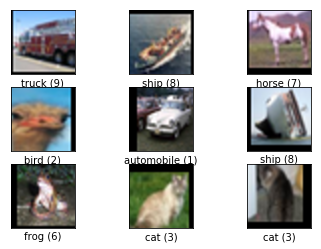

torch.Size([128, 3, 32, 32])


In [4]:
# VISUALISE
# -----------------------

# Load data without normalisations

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor()
])

train_loader, test_loader = get_data_loaders(data_dir,
                                             batch_size,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True)


# Training images
data_iter = iter(train_loader)
images, labels = data_iter.next()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

The training set consists of 50,000 32x32 pixel images. These are padded with 4 pixels on each side, before a crop is randomly sampled from the padded image or its horziontal flip. 

The authors cite C.-Y. Lee, S. Xie, P. Gallagher, Z. Zhang, and Z. Tu. Deeply-supervised nets. arXiv:1409.5185, 2014. This paper suggests that 'corner cropping' should be used which could be interpretted one of two ways:

1. There are five possible crops for each image, centre and then four further crops with the crop placed tightly in each corner. This equates to `torchvision.transforms.FiveCrop()` in PyTorch.
2. The crop position is randomly selected from any possible position within the bounds of the padded image. Equivalent to `torchvision.transforms.RandomCrop()` in PyTorch.

The intended implementation seem ambiguous to me, so I implemented the latter here largely for simplicity.

## Data augmentation: Test set

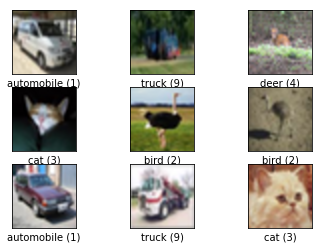

torch.Size([128, 3, 32, 32])


In [11]:
# Test images
data_iter = iter(test_loader)
images, labels = data_iter.next()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

There are 10,000 images in the test set. These are not transformed.

## Calculate normalisation parameters

The authors don't explicitly state if the images are normalised prior to training, however the paper referenced on preprocessing (C.-Y. Lee, S. Xie, P. Gallagher, Z. Zhang, and Z. Tu. Deeply-supervised nets. arXiv:1409.5185, 2014) notes that normalisation is used. 

I was unsure if the mean and standard deviation of the dataset should be calculated before or after augmentation for this purpose. It is also unclear if these calcualations should be done across the training and test set combined, or only the training set.

Her I've used the pre-transform training and test set combined.

In [6]:
# NORMALIZATION
# -----------------------
# Calculate the mean and standard deviation of each channel
# for all observations in training and test datasets. The
# results can then be used for normalisation

# Load data without transforms

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor()
])

train_loader, test_loader = get_data_loaders(data_dir,
                                             batch_size,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True)


# Takes a while to run so I've hardcoded results below

means, stds = calculate_normalisation_params(train_loader, test_loader)
print(f'means: {means}')
print(f'stds: {stds}')

Files already downloaded and verified
Files already downloaded and verified
means: [0.4918687901200927, 0.49185976472299225, 0.4918583862227116]
stds: [0.24697121702736, 0.24696766978537033, 0.2469719877121087]


## Preprocessing

Here we finalise data augmentation and normalisation parameters ahead of training.

In [11]:
# SET FINAL TRANSFORMS WITH NORMALISATION

# [x] simple data augmentation in [24]
# [x] 4 pixels are padded on each side, 
# [x] and a 32×32 crop is randomly sampled from the padded image or its horizontal flip.
# [x] For testing, we only evaluate the single view of the original 32×32 image.


# Normalisation parameters fo CIFAR10
means = [0.4918687901200927, 0.49185976472299225, 0.4918583862227116]
stds  = [0.24697121702736, 0.24696766978537033, 0.2469719877121087]

normalize = transforms.Normalize(
    mean=means,
    std=stds,
)

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor(),
    normalize
])

Notes:

- Note: downsampling with stride 2 results in uneven convolution, e.g. W_out is 16.5. Why didn't the authors use Maxpooling, would have been neater.

## Training

The authors report their results in term of training iterations. I've assumed an iteration here means a forwards and backwards pass of a batch of 128 observations through the entire network.

It seems more convenient to work in epochs in PyTorch, so here I calculate the integer number of iterations per epoch for later conversions. The results is 391 iterations per epoch. An epoch is a forwards and backwards pass for all observations in the training set.

In [15]:
# How many iterations in an epoch?

iterations = 0
for i, data in enumerate(train_loader, 0):
    iterations +=1
print(iterations)

391


### Hyperparameters

Set the hyperparameters as described by the authors, with iterations converted to epochs where appropriate.

In [13]:
# TRAINING PARAMETERS
# -------------------------

# Authors cite 64k iterations
# 64000/391 = 164
epochs = 164

# OPTIMISER PARAMETERS
lr = 0.1 # authors cite 0.1
momentum = 0.9
weight_decay = 0.0001 

# LEARNING RATE ADJUSTMENT
# Reduce learning rate at iterations 
# 32k and 48k. Convert to epochs:
# e.g. iterations / (n_observations/batch_size) 
# 32000/391 = 82
# 48000/391 = 123
milestones = [82, 123]
# Divide learning rate by 10 at each milestone
gamma = 0.1

### Plain nets

Run training loop for **'plain' convolutional networks** without shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers. 

In [17]:
# TRAIN PLAIN NETs

# n determines network size as described in paper
# where total number of layers is (6*n)+2
ns = [3, 5, 7, 9]

# Train plainnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)
    
    model = ResNet(n, shortcuts=False)
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'results/plainnet{6*n+2}.csv'
    model_file = f'pretrained/plainnet{6*n+2}.pt'
    train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

MODEL SIZE: n=3
Files already downloaded and verified
Files already downloaded and verified
MODEL SIZE: n=5
Files already downloaded and verified
Files already downloaded and verified
MODEL SIZE: n=7
Files already downloaded and verified
Files already downloaded and verified
MODEL SIZE: n=9
Files already downloaded and verified
Files already downloaded and verified


### Residual nets

Run training loop for residual networks with shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers.


In [8]:
# TRAIN RESNETs

# n determines network size as described in paper
ns = [3, 5, 7, 9]

# Train resnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)
    
    model = ResNet(n, shortcuts=True)
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'results/resnet{6*n+2}.csv'
    model_file = f'pretrained/resnet{6*n+2}.pt'
    train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

MODEL SIZE: n=3
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Epoch 	Batch 	NLLLoss_Train
1 	50 	2.622
1 	100 	1.911
1 	150 	1.797
1 	200 	1.730
1 	250 	1.662
1 	300 	1.570
1 	350 	1.508
train_err: 0.51654 test_err: 0.5428
2 	50 	1.369
2 	100 	1.345
2 	150 	1.287
2 	200 	1.222
2 	250 	1.192
2 	300 	1.181
2 	350 	1.160
train_err: 0.37676 test_err: 0.4003
3 	50 	1.046
3 	100 	1.021
3 	150 	0.971
3 	200 	0.963
3 	250 	0.934
3 	300 	0.911
3 	350 	0.873
train_err: 0.30034 test_err: 0.3264
4 	50 	0.829
4 	100 	0.789
4 	150 	0.818
4 	200 	0.792
4 	250 	0.778
4 	300 	0.758
4 	350 	0.739
train_err: 0.25896 test_err: 0.2869
5 	50 	0.706
5 	100 	0.694
5 	150 	0.693
5 	200 	0.682
5 	250 	0.662
5 	300 	0.685
5 	350 	0.677
train_err: 0.21774 test_err: 0.2556
6 	50 	0.639
6 	100 	0.633
6 	150 	0.630
6 	200 	0.629
6 	250 	0.627
6 	300 	0.614
6 	350 	0.618
train_err: 0.19232 test_err: 0.2411
7 	50 	0.580
7 	100 	0.604
7 	150 	0.583
7 	200 	0.590
7 	250 	0.563
7 	300

59 	150 	0.244
59 	200 	0.266
59 	250 	0.264
59 	300 	0.261
59 	350 	0.261
train_err: 0.07834 test_err: 0.1409
60 	50 	0.245
60 	100 	0.245
60 	150 	0.261
60 	200 	0.239
60 	250 	0.256
60 	300 	0.252
60 	350 	0.257
train_err: 0.08044 test_err: 0.1588
61 	50 	0.244
61 	100 	0.259
61 	150 	0.241
61 	200 	0.271
61 	250 	0.270
61 	300 	0.244
61 	350 	0.239
train_err: 0.08224 test_err: 0.1573
62 	50 	0.246
62 	100 	0.248
62 	150 	0.241
62 	200 	0.244
62 	250 	0.252
62 	300 	0.260
62 	350 	0.251
train_err: 0.08482 test_err: 0.1608
63 	50 	0.246
63 	100 	0.231
63 	150 	0.248
63 	200 	0.255
63 	250 	0.272
63 	300 	0.241
63 	350 	0.243
train_err: 0.083 test_err: 0.1394
64 	50 	0.240
64 	100 	0.232
64 	150 	0.250
64 	200 	0.240
64 	250 	0.270
64 	300 	0.259
64 	350 	0.269
train_err: 0.0825 test_err: 0.1526
65 	50 	0.234
65 	100 	0.253
65 	150 	0.247
65 	200 	0.242
65 	250 	0.274
65 	300 	0.258
65 	350 	0.254
train_err: 0.0789 test_err: 0.146
66 	50 	0.244
66 	100 	0.230
66 	150 	0.211
66 	200 	0

117 	100 	0.044
117 	150 	0.045
117 	200 	0.048
117 	250 	0.041
117 	300 	0.044
117 	350 	0.043
train_err: 0.0135 test_err: 0.1202
118 	50 	0.037
118 	100 	0.038
118 	150 	0.047
118 	200 	0.043
118 	250 	0.042
118 	300 	0.043
118 	350 	0.044
train_err: 0.01258 test_err: 0.1177
119 	50 	0.042
119 	100 	0.040
119 	150 	0.040
119 	200 	0.044
119 	250 	0.043
119 	300 	0.044
119 	350 	0.050
train_err: 0.01248 test_err: 0.1165
120 	50 	0.043
120 	100 	0.042
120 	150 	0.034
120 	200 	0.038
120 	250 	0.040
120 	300 	0.046
120 	350 	0.041
train_err: 0.0136 test_err: 0.1184
121 	50 	0.038
121 	100 	0.039
121 	150 	0.040
121 	200 	0.040
121 	250 	0.042
121 	300 	0.042
121 	350 	0.042
train_err: 0.01344 test_err: 0.1194
122 	50 	0.041
122 	100 	0.038
122 	150 	0.039
122 	200 	0.039
122 	250 	0.037
122 	300 	0.046
122 	350 	0.043
train_err: 0.01318 test_err: 0.1244
123 	50 	0.046
123 	100 	0.043
123 	150 	0.038
123 	200 	0.038
123 	250 	0.044
123 	300 	0.044
123 	350 	0.046
train_err: 0.01206 test_

train_err: 0.206 test_err: 0.2347
9 	50 	0.585
9 	100 	0.581
9 	150 	0.596
9 	200 	0.580
9 	250 	0.580
9 	300 	0.578
9 	350 	0.568
train_err: 0.19032 test_err: 0.2143
10 	50 	0.542
10 	100 	0.552
10 	150 	0.525
10 	200 	0.534
10 	250 	0.576
10 	300 	0.578
10 	350 	0.537
train_err: 0.18638 test_err: 0.2111
11 	50 	0.500
11 	100 	0.519
11 	150 	0.546
11 	200 	0.531
11 	250 	0.498
11 	300 	0.539
11 	350 	0.516
train_err: 0.16762 test_err: 0.1968
12 	50 	0.513
12 	100 	0.478
12 	150 	0.497
12 	200 	0.517
12 	250 	0.492
12 	300 	0.514
12 	350 	0.483
train_err: 0.16008 test_err: 0.1878
13 	50 	0.486
13 	100 	0.476
13 	150 	0.498
13 	200 	0.485
13 	250 	0.465
13 	300 	0.429
13 	350 	0.472
train_err: 0.14896 test_err: 0.1853
14 	50 	0.462
14 	100 	0.444
14 	150 	0.465
14 	200 	0.456
14 	250 	0.450
14 	300 	0.457
14 	350 	0.463
train_err: 0.14734 test_err: 0.1866
15 	50 	0.440
15 	100 	0.442
15 	150 	0.437
15 	200 	0.452
15 	250 	0.432
15 	300 	0.455
15 	350 	0.455
train_err: 0.14738 test_err: 

67 	300 	0.255
67 	350 	0.247
train_err: 0.07126 test_err: 0.1424
68 	50 	0.201
68 	100 	0.185
68 	150 	0.216
68 	200 	0.227
68 	250 	0.201
68 	300 	0.229
68 	350 	0.231
train_err: 0.07476 test_err: 0.153
69 	50 	0.209
69 	100 	0.205
69 	150 	0.213
69 	200 	0.226
69 	250 	0.234
69 	300 	0.210
69 	350 	0.239
train_err: 0.07148 test_err: 0.1447
70 	50 	0.204
70 	100 	0.217
70 	150 	0.220
70 	200 	0.213
70 	250 	0.237
70 	300 	0.219
70 	350 	0.222
train_err: 0.07168 test_err: 0.1444
71 	50 	0.220
71 	100 	0.215
71 	150 	0.218
71 	200 	0.219
71 	250 	0.216
71 	300 	0.228
71 	350 	0.227
train_err: 0.07302 test_err: 0.1403
72 	50 	0.225
72 	100 	0.196
72 	150 	0.226
72 	200 	0.223
72 	250 	0.193
72 	300 	0.213
72 	350 	0.239
train_err: 0.07122 test_err: 0.1501
73 	50 	0.213
73 	100 	0.220
73 	150 	0.211
73 	200 	0.223
73 	250 	0.226
73 	300 	0.225
73 	350 	0.234
train_err: 0.0678 test_err: 0.1453
74 	50 	0.208
74 	100 	0.196
74 	150 	0.214
74 	200 	0.206
74 	250 	0.207
74 	300 	0.216
74 	350

125 	50 	0.020
125 	100 	0.014
125 	150 	0.018
125 	200 	0.021
125 	250 	0.017
125 	300 	0.018
125 	350 	0.019
train_err: 0.00558 test_err: 0.1139
126 	50 	0.018
126 	100 	0.020
126 	150 	0.014
126 	200 	0.022
126 	250 	0.019
126 	300 	0.016
126 	350 	0.021
train_err: 0.00434 test_err: 0.1118
127 	50 	0.016
127 	100 	0.017
127 	150 	0.017
127 	200 	0.018
127 	250 	0.017
127 	300 	0.014
127 	350 	0.014
train_err: 0.00458 test_err: 0.1107
128 	50 	0.015
128 	100 	0.019
128 	150 	0.017
128 	200 	0.018
128 	250 	0.017
128 	300 	0.016
128 	350 	0.017
train_err: 0.0044 test_err: 0.111
129 	50 	0.013
129 	100 	0.016
129 	150 	0.017
129 	200 	0.017
129 	250 	0.014
129 	300 	0.015
129 	350 	0.016
train_err: 0.00412 test_err: 0.1107
130 	50 	0.015
130 	100 	0.017
130 	150 	0.013
130 	200 	0.014
130 	250 	0.013
130 	300 	0.016
130 	350 	0.016
train_err: 0.00436 test_err: 0.1121
131 	50 	0.018
131 	100 	0.015
131 	150 	0.015
131 	200 	0.014
131 	250 	0.015
131 	300 	0.017
131 	350 	0.015
train_err

17 	100 	0.374
17 	150 	0.379
17 	200 	0.388
17 	250 	0.373
17 	300 	0.384
17 	350 	0.387
train_err: 0.1158 test_err: 0.1888
18 	50 	0.347
18 	100 	0.360
18 	150 	0.365
18 	200 	0.384
18 	250 	0.372
18 	300 	0.374
18 	350 	0.375
train_err: 0.12184 test_err: 0.1973
19 	50 	0.348
19 	100 	0.360
19 	150 	0.342
19 	200 	0.352
19 	250 	0.374
19 	300 	0.395
19 	350 	0.348
train_err: 0.1179 test_err: 0.178
20 	50 	0.328
20 	100 	0.376
20 	150 	0.374
20 	200 	0.322
20 	250 	0.356
20 	300 	0.317
20 	350 	0.376
train_err: 0.10952 test_err: 0.1855
21 	50 	0.339
21 	100 	0.345
21 	150 	0.310
21 	200 	0.316
21 	250 	0.330
21 	300 	0.328
21 	350 	0.334
train_err: 0.11716 test_err: 0.1996
22 	50 	0.325
22 	100 	0.317
22 	150 	0.316
22 	200 	0.312
22 	250 	0.321
22 	300 	0.344
22 	350 	0.326
train_err: 0.1172 test_err: 0.1849
23 	50 	0.318
23 	100 	0.299
23 	150 	0.336
23 	200 	0.310
23 	250 	0.333
23 	300 	0.327
23 	350 	0.310
train_err: 0.09776 test_err: 0.1803
24 	50 	0.309
24 	100 	0.310
24 	150 	

76 	50 	0.176
76 	100 	0.183
76 	150 	0.186
76 	200 	0.154
76 	250 	0.199
76 	300 	0.196
76 	350 	0.210
train_err: 0.05914 test_err: 0.1509
77 	50 	0.166
77 	100 	0.169
77 	150 	0.184
77 	200 	0.196
77 	250 	0.194
77 	300 	0.189
77 	350 	0.207
train_err: 0.06442 test_err: 0.1515
78 	50 	0.187
78 	100 	0.170
78 	150 	0.182
78 	200 	0.196
78 	250 	0.175
78 	300 	0.185
78 	350 	0.192
train_err: 0.05622 test_err: 0.1444
79 	50 	0.172
79 	100 	0.160
79 	150 	0.172
79 	200 	0.184
79 	250 	0.215
79 	300 	0.215
79 	350 	0.189
train_err: 0.05948 test_err: 0.1473
80 	50 	0.181
80 	100 	0.169
80 	150 	0.175
80 	200 	0.185
80 	250 	0.200
80 	300 	0.193
80 	350 	0.187
train_err: 0.06004 test_err: 0.1527
81 	50 	0.176
81 	100 	0.177
81 	150 	0.186
81 	200 	0.184
81 	250 	0.192
81 	300 	0.182
81 	350 	0.200
train_err: 0.06124 test_err: 0.1498
82 	50 	0.174
82 	100 	0.174
82 	150 	0.165
82 	200 	0.175
82 	250 	0.182
82 	300 	0.187
82 	350 	0.203
train_err: 0.0588 test_err: 0.1521
83 	50 	0.187
83 	100

133 	50 	0.008
133 	100 	0.008
133 	150 	0.008
133 	200 	0.008
133 	250 	0.009
133 	300 	0.009
133 	350 	0.008
train_err: 0.00206 test_err: 0.1158
134 	50 	0.007
134 	100 	0.008
134 	150 	0.007
134 	200 	0.009
134 	250 	0.007
134 	300 	0.008
134 	350 	0.008
train_err: 0.00202 test_err: 0.1121
135 	50 	0.006
135 	100 	0.009
135 	150 	0.007
135 	200 	0.009
135 	250 	0.009
135 	300 	0.008
135 	350 	0.006
train_err: 0.00186 test_err: 0.111
136 	50 	0.009
136 	100 	0.010
136 	150 	0.007
136 	200 	0.008
136 	250 	0.007
136 	300 	0.008
136 	350 	0.010
train_err: 0.00196 test_err: 0.1159
137 	50 	0.008
137 	100 	0.008
137 	150 	0.008
137 	200 	0.008
137 	250 	0.006
137 	300 	0.007
137 	350 	0.007
train_err: 0.00178 test_err: 0.1146
138 	50 	0.008
138 	100 	0.008
138 	150 	0.008
138 	200 	0.006
138 	250 	0.008
138 	300 	0.008
138 	350 	0.008
train_err: 0.0017 test_err: 0.1135
139 	50 	0.008
139 	100 	0.008
139 	150 	0.011
139 	200 	0.009
139 	250 	0.009
139 	300 	0.009
139 	350 	0.009
train_err

25 	300 	0.296
25 	350 	0.316
train_err: 0.10636 test_err: 0.1572
26 	50 	0.268
26 	100 	0.294
26 	150 	0.279
26 	200 	0.299
26 	250 	0.313
26 	300 	0.291
26 	350 	0.287
train_err: 0.09366 test_err: 0.1394
27 	50 	0.262
27 	100 	0.280
27 	150 	0.278
27 	200 	0.299
27 	250 	0.311
27 	300 	0.295
27 	350 	0.288
train_err: 0.09462 test_err: 0.142
28 	50 	0.271
28 	100 	0.271
28 	150 	0.276
28 	200 	0.291
28 	250 	0.279
28 	300 	0.301
28 	350 	0.274
train_err: 0.08998 test_err: 0.1454
29 	50 	0.248
29 	100 	0.278
29 	150 	0.282
29 	200 	0.294
29 	250 	0.273
29 	300 	0.281
29 	350 	0.292
train_err: 0.09162 test_err: 0.1386
30 	50 	0.245
30 	100 	0.270
30 	150 	0.236
30 	200 	0.278
30 	250 	0.272
30 	300 	0.269
30 	350 	0.298
train_err: 0.08414 test_err: 0.138
31 	50 	0.244
31 	100 	0.252
31 	150 	0.261
31 	200 	0.274
31 	250 	0.281
31 	300 	0.258
31 	350 	0.257
train_err: 0.08726 test_err: 0.1477
32 	50 	0.252
32 	100 	0.256
32 	150 	0.262
32 	200 	0.275
32 	250 	0.254
32 	300 	0.273
32 	350

84 	200 	0.080
84 	250 	0.085
84 	300 	0.080
84 	350 	0.082
train_err: 0.021 test_err: 0.0954
85 	50 	0.058
85 	100 	0.063
85 	150 	0.063
85 	200 	0.064
85 	250 	0.061
85 	300 	0.060
85 	350 	0.061
train_err: 0.01658 test_err: 0.095
86 	50 	0.057
86 	100 	0.052
86 	150 	0.051
86 	200 	0.050
86 	250 	0.053
86 	300 	0.055
86 	350 	0.049
train_err: 0.01354 test_err: 0.094
87 	50 	0.041
87 	100 	0.046
87 	150 	0.041
87 	200 	0.047
87 	250 	0.046
87 	300 	0.046
87 	350 	0.048
train_err: 0.0126 test_err: 0.0929
88 	50 	0.043
88 	100 	0.040
88 	150 	0.037
88 	200 	0.042
88 	250 	0.039
88 	300 	0.039
88 	350 	0.040
train_err: 0.0116 test_err: 0.0926
89 	50 	0.039
89 	100 	0.037
89 	150 	0.035
89 	200 	0.033
89 	250 	0.040
89 	300 	0.039
89 	350 	0.036
train_err: 0.0101 test_err: 0.0906
90 	50 	0.031
90 	100 	0.031
90 	150 	0.029
90 	200 	0.031
90 	250 	0.036
90 	300 	0.035
90 	350 	0.037
train_err: 0.00888 test_err: 0.0961
91 	50 	0.031
91 	100 	0.033
91 	150 	0.032
91 	200 	0.035
91 	250 	0.0

141 	50 	0.005
141 	100 	0.006
141 	150 	0.006
141 	200 	0.005
141 	250 	0.005
141 	300 	0.005
141 	350 	0.006
train_err: 0.00096 test_err: 0.096
142 	50 	0.005
142 	100 	0.005
142 	150 	0.005
142 	200 	0.004
142 	250 	0.006
142 	300 	0.007
142 	350 	0.006
train_err: 0.00104 test_err: 0.0941
143 	50 	0.005
143 	100 	0.005
143 	150 	0.004
143 	200 	0.005
143 	250 	0.005
143 	300 	0.006
143 	350 	0.005
train_err: 0.00114 test_err: 0.095
144 	50 	0.005
144 	100 	0.004
144 	150 	0.004
144 	200 	0.005
144 	250 	0.005
144 	300 	0.005
144 	350 	0.005
train_err: 0.00098 test_err: 0.0953
145 	50 	0.006
145 	100 	0.004
145 	150 	0.005
145 	200 	0.006
145 	250 	0.004
145 	300 	0.005
145 	350 	0.005
train_err: 0.00106 test_err: 0.0973
146 	50 	0.004
146 	100 	0.005
146 	150 	0.004
146 	200 	0.005
146 	250 	0.004
146 	300 	0.005
146 	350 	0.005
train_err: 0.001 test_err: 0.0952
147 	50 	0.005
147 	100 	0.005
147 	150 	0.005
147 	200 	0.004
147 	250 	0.006
147 	300 	0.005
147 	350 	0.006
train_err: 

### Check model

Table 6. in the paper reports that the ResNet model with 20 layers should have 0.27 million trainable parameters. We reproduce that here.

It is noted elsewhere that the plain net should have the same number of parameters for the CIFAR10 experiment. This is because an identity mapping is used for the residual shortcuts, as opposed to a convolutional layer, an so there are no additional trainable parameters.

In [12]:
print(f'Parameter count: {sum([p.numel() for p in model.parameters()])}')

Parameter count: 270410


The PyTorch model architecture for a 20 layer model.

In [15]:
print(model)

ResNet(
  (convIn): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnIn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (relu): ReLU(inplace)
  (stack1): ModuleList(
    (0): block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (relu): ReLU(inplace)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (down): AvgPool2d(kernel_size=1, stride=2, padding=0)
    )
    (1): block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (relu): ReLU(inplace)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Bat

## Analysis

### Plain net

First we compare the performance of 'plain' convolutional networks of various depths. This corresponds to the left-hand axis of Figure. 6 in the paper. 

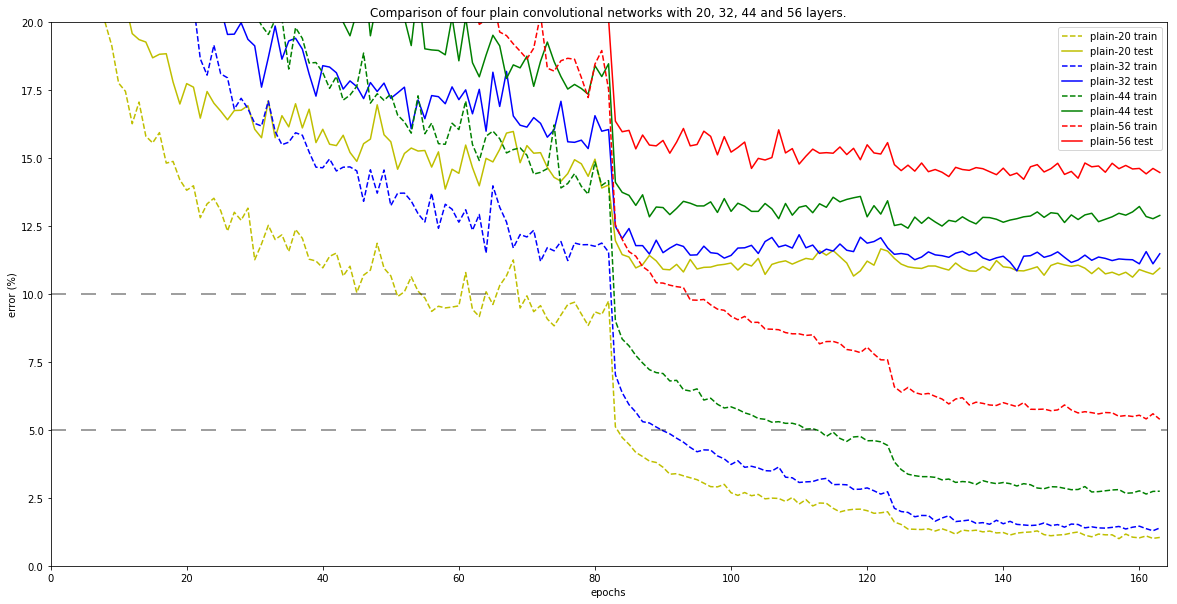

In [45]:
ns  = [3, 5, 7, 9]
clr = ['y', 'b', 'g', 'r']


plot_dfs = [pd.read_csv(f'results/plainnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 164, 0, 20])


for i in range(len(ns)):
    plt.plot(plot_dfs[i]['epoch'], plot_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'plain-{6*ns[i]+2} train')
    plt.plot(plot_dfs[i]['epoch'], plot_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'plain-{6*ns[i]+2} test')

plt.title('Comparison of four plain convolutional networks with 20, 32, 44 and 56 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [41]:
bests = [df[df['test_err'] == df['test_err'].min()] for df in plot_dfs]
bests_df = pd.DataFrame(pd.concat(bests, axis=0))
bests_df['model'] = ['PlainNet20', 'PlainNet32', 'PlainNet44', 'PlainNet56']
display(bests_df[['model', 'test_err']])

,model,test_err
159,PlainNet20,0.1062
142,PlainNet32,0.1085
126,PlainNet44,0.1242
143,PlainNet56,0.1422


In this experiment the shallowest 20-layer 'plain' network achieves the lowest test error of around 10.6%. Test error increases with network depth. The deepest 56 layer network achieves a test error around 14.2%.

The observation of poorer performance for deeper 'plain' networks supports the authors. 

The test errors observed appear to be ~1% higher than those shown in the left-hand plot of Figure. 6. We observe a slightly faster decrease in training error relative to test error, suggesting that the models tested here are more prone to overfit.

### Resnet

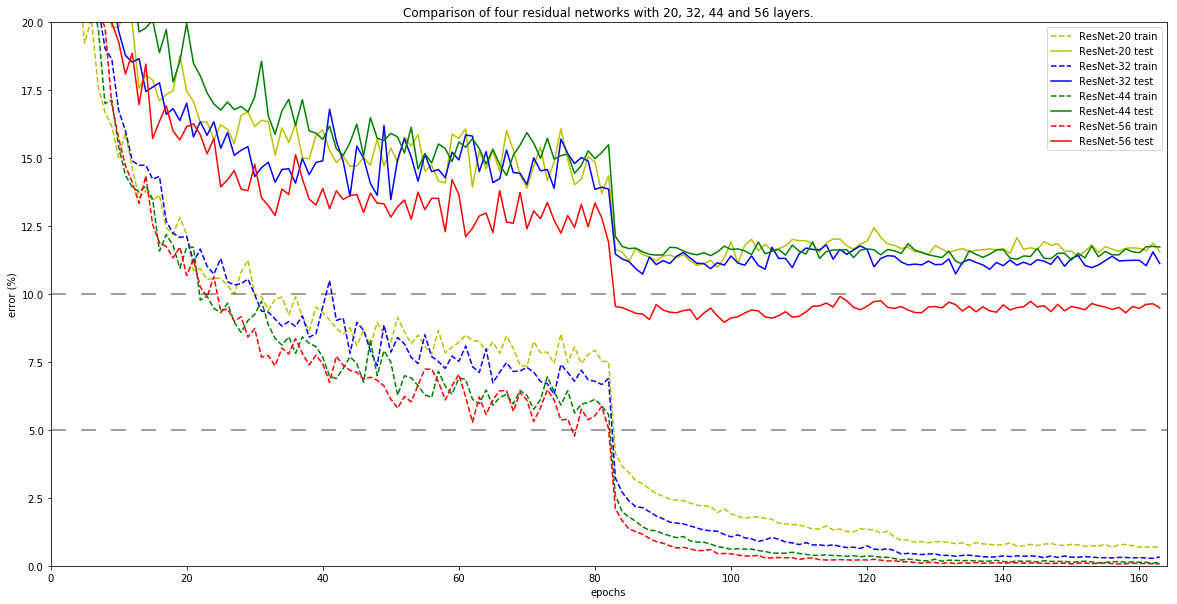

In [47]:
ns  = [3, 5, 7, 9]
clr = ['y', 'b', 'g', 'r']

plot_dfs = [pd.read_csv(f'results/resnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 164, 0, 20])


for i in range(len(ns)):
    plt.plot(plot_dfs[i]['epoch'], plot_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'ResNet-{6*ns[i]+2} train')
    plt.plot(plot_dfs[i]['epoch'], plot_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'ResNet-{6*ns[i]+2} test')

plt.title('Comparison of four residual networks with 20, 32, 44 and 56 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [44]:
bests = [df[df['test_err'] == df['test_err'].min()] for df in plot_dfs]
bests_df = pd.DataFrame(pd.concat(bests, axis=0))
bests_df['model'] = ['ResNet20', 'ResNet32', 'ResNet44', 'ResNet56']
display(bests_df[['model', 'test_err']])

,model,test_err
98,ResNet20,0.1098
87,ResNet32,0.1073
134,ResNet44,0.1110
99,ResNet56,0.0896


Here we test residual networks of increasing depth. The deepest 56 layer network achieves the lowest test error of 9%. The shallowest 20 layer network performs the worst with a test error of 11%. The 32 layer network outperforms the 44 layer network. 


### Conclusion

The key observation of the original paper was that residual layers enable deep networks to outperform shallower networks. That observation is reproduced here with the deepest 56 layer residual network outperforming all other networks tested, whilst the equivalent 56 layer plain network performed the worst.

The original paper also reported that residual layers improved the performance of smaller networks too, for example in Figure 6 the 20 layer ResNet outperforms its 'plain' counterpart. That result is not reproduced here. Instead the plain 20 layer network slightly outperforms the residual equivalent with test errors of 10.6% and 11% respectively.

Finally we observe higher test errors for all experiments with a discrepency of around 2%. I only ran each experiment once and so the variance between experiments is unknown, however the authors report a standard deviation of 0.16% for the 110 layer experiment suggesting a 2% discrepency is likely significant. This could be attributed to the cropping algorithm chosen in data augmentation, or perhaps a difference in the implementation of batch normalisation. Another possibility is that the authors might have implemented pooling following the first layer, which is ambiguous in the paper and not implemented here.